In [ ]:
#!pip install --upgrade cupy-cuda112==8.5.0
!nvidia-smi

Tue Jun  8 22:14:21 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   50C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import cupy as cp
import math
from time import time

In [ ]:
#@title CustomKernel
import cupy as cp
import torch

@cp.util.memoize(for_each_device=True)
def cunnex(func_name, func_body):
  return cp.cuda.compile_with_cache(func_body).get_function(func_name)

class Stream:
  def __init__(self, ptr):
    self.ptr = ptr
  
class CustomKernel:
  def __init__(self):
    self._use_torch_in_cupy_malloc()
    self.stream = Stream(torch.cuda.current_stream().cuda_stream)

  @staticmethod
  def _torch_alloc(size):
    device = cp.cuda.Device().id
    tensor = torch.empty(size, dtype=torch.uint8, device=device)
    return cp.cuda.MemoryPointer(
        cp.cuda.UnownedMemory(tensor.data_ptr(), size, tensor), 0)

  def _use_torch_in_cupy_malloc(self):
    cp.cuda.set_allocator(self._torch_alloc)

  def _compile_kernel_str(
      self,
      kernel,
      name,
      options=(),
      backend="nvrtc",
      max_dynamic_smem=None
    ):
    fn = cp.RawKernel(
      kernel,
      name,
      options=options,
      backend=backend,
    )
    if max_dynamic_smem:
      fn.max_dynamic_shared_size_bytes = max_dynamic_smem
    return fn

In [ ]:
#@title bmm_helpers.cu
kernel = """
#define likely(x)      __builtin_expect(!!(x), 1)
#define unlikely(x)    __builtin_expect(!!(x), 0)
#define load(x)        __ldcg(x)
#define store(x, value) __stcs(x, value)

#define _VOLATILE_  

#define likely(x)      __builtin_expect(!!(x), 1)
#define unlikely(x)    __builtin_expect(!!(x), 0)
#define load(x)        __ldcg(x)
#define store(x, value) __stcs(x, value)

typedef long long ll_t;
typedef unsigned long long ull_t;

typedef struct __builtin_align__(32) {
  float s0, s1, s2, s3, s4, s5, s6, s7;
} _float8;

typedef union {
  _float8 f8;
  float val[8];
} float8;

__device__ void madd(
  float a,
  float b,
  float &c
) {
  c = fmaf(a, b, c);
}

__device__ void squared_l2(
  float a,
  float b,
  float &c
){
  float dif = a - b;
  c = fmaf(dif, dif, c);
}

__device__ void negative_squared_l2(
  float a,
  float b,
  float &c
){
  float dif = a - b;
  c = fmaf(-dif, dif, c);
}

__device__ void l1(
  float a,
  float b,
  float &c
){
  c += fabsf(a - b);
}

__device__ void negative_l1(
  float a,
  float b,
  float &c
){
  c -= fabsf(a - b);
}

__device__ void thread_matmul_v4(
  _VOLATILE_ float aSM[8][128+4],
  _VOLATILE_ float bSM[8][128+4],
  float8 cCache[8],
  int vx, int vy
) {
  float aCache1[8];
  float aCache2[8];
  #pragma unroll
  for (int mi=0; mi<8; mi++){
    aCache1[mi] = aSM[0][8*vy + mi];
  }

  #pragma unroll
  for (int ki=0; ki<8; ki++){
    int is_odd = ki & 1;
    if (is_odd == 0){
      if (likely(ki < 7)){
        #pragma unroll
        for (int mi=0; mi<8; mi++){
          aCache2[mi] = aSM[ki+1][8*vy + mi];
        }
      }
      #pragma unroll
      for (int ni=0; ni<8; ni++){
        float b = bSM[ki][vx/4 + 8*vx + ni];
        #pragma unroll
        for (int mi=0; mi<8; mi++){
          float a = aCache1[mi];
          cCache[mi].val[ni] = fmaf(a, b, cCache[mi].val[ni]);
        }
      }
    } else {
      if (likely(ki < 7)){
        #pragma unroll
        for (int mi=0; mi<8; mi++){
          aCache1[mi] = aSM[ki+1][8*vy + mi];
        }
      }
      #pragma unroll
      for (int ni=0; ni<8; ni++){
        float b = bSM[ki][vx/4 + 8*vx + ni];
        #pragma unroll
        for (int mi=0; mi<8; mi++){
          float a = aCache2[mi];
          cCache[mi].val[ni] = fmaf(a, b, cCache[mi].val[ni]);
        }
      }
    }
  }
}

__device__ void thread_matmul_16_v3(
  _VOLATILE_ float aSM[16][128+4],
  _VOLATILE_ float bSM[16][128+4],
  float8 cCache[8],
  int vx, int vy
) {
  float aCache[8];

  #pragma unroll
  for (int ki=0; ki<16; ki++){
    #pragma unroll
    for (int mi=0; mi<8; mi++){
      aCache[mi] = aSM[ki][8*vy + mi];
    }
    #pragma unroll
    for (int ni=0; ni<8; ni++){
      float b = bSM[ki][vx/4 + 8*vx + ni];
      #pragma unroll
      for (int mi=0; mi<8; mi++){
        float a = aCache[mi];
        __DISTANCE_FN__(a, b, cCache[mi].val[ni]);
      }
    }
  }
}

__device__ void thread_matmul_v3(
  _VOLATILE_ float aSM[8][128+4],
  _VOLATILE_ float bSM[8][128+4],
  float8 cCache[8],
  int vx, int vy
) {
  float aCache[8];

  #pragma unroll
  for (int ki=0; ki<8; ki++){
    #pragma unroll
    for (int mi=0; mi<8; mi++){
      aCache[mi] = aSM[ki][8*vy + mi];
    }
    #pragma unroll
    for (int ni=0; ni<8; ni++){
      float b = bSM[ki][vx/4 + 8*vx + ni];
      #pragma unroll
      for (int mi=0; mi<8; mi++){
        float a = aCache[mi];
        __DISTANCE_FN__(a, b, cCache[mi].val[ni]);
      }
    }
  }
}

__device__ void init_cCache(
  float8 cCache[8]
) {
  #pragma unroll
  for (int i=0; i<8; i++){
    #pragma unroll
    for (int j=0; j<8; j++){
      cCache[i].val[j] = 0.f;
    }
  }
}


// Unsafe
__device__ void write_c(
  float8 cCache[8],
  float* C,
  int gStartx, int gStarty,
  int vx, int vy, int bid,
  int M, int N
) {
  #pragma unroll
  for (int i=0; i<8; i++){
    int iM = gStarty + vy*8 + i;
    if (likely(iM < M)){
      int iN_start = gStartx + vx*8;
      reinterpret_cast<float8*>(C + (bid)*M*N + (iM)*N + (iN_start))[0] = cCache[i];
      /*
      if (likely(iN_start + 7 < N)){
        reinterpret_cast<float8*>(C + (bid)*M*N + (iM)*N + (iN_start))[0] = cCache[i];
      } else {
        #pragma unroll
        for (int j=0; j<8; j++){
          int iN = iN_start + j;
          if (iN < N){
            C[(bid)*M*N + (iM)*N + (iN)] = cCache[i].val[j];
          }
        }
      }
      */
    }
  }
}

__device__ void write_c_v3(
  float8 cCache[8],
  float* C,
  int gStartx, int gStarty,
  int vx, int vy, int bid,
  int M, int N
) {
  __shared__ volatile float cSM[16][128];
  #pragma unroll
  for (int mi=0; mi<8; mi++){
    int iM = gStarty + vy*8 + mi;
    // Store 1 row from cCache to cSM
    if (iM < M){
      #pragma unroll
      for (int ni=0; ni<8; ni++){
        cSM[vy][vx*8 + ni] = cCache[mi].val[ni];
      }
      // Store to C
      #pragma unroll
      for (int ni=0; ni<8; ni++){
        int iN = gStartx + 16*ni + vx;
        if (iN < N){
          float cVal = cSM[vy][16*ni + vx];
          store(C+(bid)*M*N + (iM)*N + (iN), cVal);
        }
      }
    }
  } 
}

__device__ void load_ab_nn(
  const float* A,
  const float* B,
  float aBuffer1[4],
  float aBuffer2[4],
  float bBuffer1[4],
  float bBuffer2[4],
  int bid, int gStartx, int gStarty, int gStartk,
  int M, int N, int K
){
  int tid = threadIdx.x;
  int wx = tid % 32;
  int wy = tid / 32;
  int dx = tid % 8;
  int dy = tid / 8;
  int iKA = gStartk + dx;
  int iKB = gStartk + wy;
  #pragma unroll
  for (int i=0; i<4; i++){
    int iM = gStarty + dy + i*32;
    int iN = gStartx + wx + i*32;
    if (likely(iM < M)){
      if (likely(iKA < K)){
        aBuffer1[i] = load(A + (bid)*M*K + (iM)*K + (iKA));
      } else {
        aBuffer1[i] = 0.f;
      }
      if (likely(iKA+8 < K)){
        aBuffer2[i] = load(A + (bid)*M*K + (iM)*K + (iKA+8));
      } else {
        aBuffer2[i] = 0.f;
      }
    }
    if (likely(iN < N)){
      if (likely(iKB < K)){
        bBuffer1[i] = load(B + (bid)*N*K + (iKB)*N + (iN));
      } else {
        bBuffer1[i] = 0.f;
      }
      if (likely(iKB+8 < K)){
        bBuffer2[i] = load(B + (bid)*N*K + (iKB+8)*N + (iN));
      } else {
        bBuffer2[i] = 0.f;
      }
    }
  }
}

__device__ void load_ab_tt(
  const float* A,
  const float* B,
  float aBuffer1[4],
  float aBuffer2[4],
  float bBuffer1[4],
  float bBuffer2[4],
  int bid, int gStartx, int gStarty, int gStartk,
  int M, int N, int K
){
  int tid = threadIdx.x;
  int wx = tid % 32;
  int wy = tid / 32;
  int dx = tid % 8;
  int dy = tid / 8;
  int iKA = gStartk + wy;
  int iKB = gStartk + dx;
  #pragma unroll
  for (int i=0; i<4; i++){
    int iM = gStarty + wx + i*32;
    int iN = gStartx + dy + i*32;
    if (likely(iM < M)){
      if (likely(iKA < K)){
        aBuffer1[i] = load(A + (bid)*M*K + (iKA)*M + (iM));
      } else {
        aBuffer1[i] = 0.f;
      }
      if (likely(iKA+8 < K)){
        aBuffer2[i] = load(A + (bid)*M*K + (iKA+8)*M + (iM));
      } else {
        aBuffer2[i] = 0.f;
      }
    }
    if (likely(iN < N)){
      if (likely(iKB < K)){
        bBuffer1[i] = load(B + (bid)*N*K + (iN)*K + (iKB));
      } else {
        bBuffer1[i] = 0.f;
      }
      if (likely(iKB+8 < K)){
        bBuffer2[i] = load(B + (bid)*N*K + (iN)*K + (iKB+8));
      } else {
        bBuffer2[i] = 0.f;
      }
    }
  }
}

__device__ void load_ab_nt(
  const float* A,
  const float* B,
  float aBuffer1[4],
  float aBuffer2[4],
  float bBuffer1[4],
  float bBuffer2[4],
  int bid, int gStartx, int gStarty, int gStartk,
  int M, int N, int K
){
  int tid = threadIdx.x;
  int wx = tid % 32;
  int wy = tid / 32;
  int dx = tid % 8;
  int dy = tid / 8;
  int iKA = gStartk + dx;
  int iKB = gStartk + dx;
  #pragma unroll
  for (int i=0; i<4; i++){
    int iM = gStarty + dy + i*32;
    int iN = gStartx + dy + i*32;
    if (likely(iM < M)){
      if (likely(iKA < K)){
        aBuffer1[i] = load(A + (bid)*M*K + (iM)*K + (iKA));
      } else {
        aBuffer1[i] = 0.f;
      }
      if (likely(iKA+8 < K)){
        aBuffer2[i] = load(A + (bid)*M*K + (iM)*K + (iKA+8));
      } else {
        aBuffer2[i] = 0.f;
      }
    }
    if (likely(iN < N)){
      if (likely(iKB < K)){
        bBuffer1[i] = load(B + (bid)*N*K + (iN)*K + (iKB));
      } else {
        bBuffer1[i] = 0.f;
      }
      if (likely(iKB+8 < K)){
        bBuffer2[i] = load(B + (bid)*N*K + (iN)*K + (iKB+8));
      } else {
        bBuffer2[i] = 0.f;
      }
    }
  }
}

__device__ void load_ab_tn(
  const float* A,
  const float* B,
  float aBuffer1[4],
  float aBuffer2[4],
  float bBuffer1[4],
  float bBuffer2[4],
  int bid, int gStartx, int gStarty, int gStartk,
  int M, int N, int K
){
  int tid = threadIdx.x;
  int wx = tid % 32;
  int wy = tid / 32;
  int dx = tid % 8;
  int dy = tid / 8;
  int iKA = gStartk + wy;
  int iKB = gStartk + wy;
  #pragma unroll
  for (int i=0; i<4; i++){
    int iM = gStarty + wx + i*32;
    int iN = gStartx + wx + i*32;
    if (likely(iM < M)){
      if (likely(iKA < K)){
        aBuffer1[i] = load(A + (bid)*M*K + (iKA)*M + (iM));
      } else {
        aBuffer1[i] = 0.f;
      }
      if (likely(iKA+8 < K)){
        aBuffer2[i] = load(A + (bid)*M*K + (iKA+8)*M + (iM));
      } else {
        aBuffer2[i] = 0.f;
      }
    }
    if (likely(iN < N)){
      if (likely(iKB < K)){
        bBuffer1[i] = load(B + (bid)*N*K + (iKB)*N + (iN));
      } else {
        bBuffer1[i] = 0.f;
      }
      if (likely(iKB+8 < K)){
        bBuffer2[i] = load(B + (bid)*N*K + (iKB+8)*N + (iN));
      } else {
        bBuffer2[i] = 0.f;
      }
    }
  }
}

__device__ void buffer2smem_nn(
  _VOLATILE_ float aSM1[8][128+4],
  _VOLATILE_ float aSM2[8][128+4],
  _VOLATILE_ float bSM1[8][128+4],
  _VOLATILE_ float bSM2[8][128+4],
  float aBuffer1[4],
  float aBuffer2[4],
  float bBuffer1[4],
  float bBuffer2[4]
){
  int tid = threadIdx.x;
  int wx = tid % 32;
  int wy = tid / 32;
  int dx = tid % 8;
  int dy = tid / 8;
  #pragma unroll
  for (int i=0; i<4; i++){
    // Store buffered tiles into shared memory
    aSM1[dx][dy+i*32] = aBuffer1[i];
    bSM1[wy][wx+i*32+i] = bBuffer1[i];
    aSM2[dx][dy+i*32] = aBuffer2[i];
    bSM2[wy][wx+i*32+i] = bBuffer2[i];
  }
}

__device__ void buffer2smem_tt(
  _VOLATILE_ float aSM1[8][128+4],
  _VOLATILE_ float aSM2[8][128+4],
  _VOLATILE_ float bSM1[8][128+4],
  _VOLATILE_ float bSM2[8][128+4],
  float aBuffer1[4],
  float aBuffer2[4],
  float bBuffer1[4],
  float bBuffer2[4]
){
  int tid = threadIdx.x;
  int wx = tid % 32;
  int wy = tid / 32;
  int dx = tid % 8;
  int dy = tid / 8;
  #pragma unroll
  for (int i=0; i<4; i++){
    // Store buffered tiles into shared memory
    aSM1[wy][wx+i*32] = aBuffer1[i];
    aSM2[wy][wx+i*32] = aBuffer2[i];
    bSM1[dx][dy+i*32+i] = bBuffer1[i];
    bSM2[dx][dy+i*32+i] = bBuffer2[i];
  }
}

__device__ void buffer2smem_nt(
  _VOLATILE_ float aSM1[8][128+4],
  _VOLATILE_ float aSM2[8][128+4],
  _VOLATILE_ float bSM1[8][128+4],
  _VOLATILE_ float bSM2[8][128+4],
  float aBuffer1[4],
  float aBuffer2[4],
  float bBuffer1[4],
  float bBuffer2[4]
){
  int tid = threadIdx.x;
  int wx = tid % 32;
  int wy = tid / 32;
  int dx = tid % 8;
  int dy = tid / 8;
  #pragma unroll
  for (int i=0; i<4; i++){
    // Store buffered tiles into shared memory
    aSM1[dx][dy+i*32] = aBuffer1[i];
    aSM2[dx][dy+i*32] = aBuffer2[i];
    bSM1[dx][dy+i*32+i] = bBuffer1[i];
    bSM2[dx][dy+i*32+i] = bBuffer2[i];
  }
}

__device__ void buffer2smem_tn(
  _VOLATILE_ float aSM1[8][128+4],
  _VOLATILE_ float aSM2[8][128+4],
  _VOLATILE_ float bSM1[8][128+4],
  _VOLATILE_ float bSM2[8][128+4],
  float aBuffer1[4],
  float aBuffer2[4],
  float bBuffer1[4],
  float bBuffer2[4]
){
  int tid = threadIdx.x;
  int wx = tid % 32;
  int wy = tid / 32;
  int dx = tid % 8;
  int dy = tid / 8;
  #pragma unroll
  for (int i=0; i<4; i++){
    // Store buffered tiles into shared memory
    aSM1[wy][wx+i*32] = aBuffer1[i];
    aSM2[wy][wx+i*32] = aBuffer2[i];
    bSM1[wy][wx+i*32+i] = bBuffer1[i];
    bSM2[wy][wx+i*32+i] = bBuffer2[i];
  }
}

__device__ void buffer2smem_16_nn(
  _VOLATILE_ float aSM[16][128+4],
  _VOLATILE_ float bSM[16][128+4],
  float aBuffer1[4],
  float aBuffer2[4],
  float bBuffer1[4],
  float bBuffer2[4]
){
  int tid = threadIdx.x;
  int wx = tid % 32;
  int wy = tid / 32;
  int dx = tid % 8;
  int dy = tid / 8;
  #pragma unroll
  for (int i=0; i<4; i++){
    // Store buffered tiles into shared memory
    aSM[dx][dy+i*32] = aBuffer1[i];
    aSM[dx+8][dy+i*32] = aBuffer2[i];
    bSM[wy][wx+i*32+i] = bBuffer1[i];
    bSM[wy+8][wx+i*32+i] = bBuffer2[i];
  }
}

__device__ void buffer2smem_16_tt(
  _VOLATILE_ float aSM[16][128+4],
  _VOLATILE_ float bSM[16][128+4],
  float aBuffer1[4],
  float aBuffer2[4],
  float bBuffer1[4],
  float bBuffer2[4]
){
  int tid = threadIdx.x;
  int wx = tid % 32;
  int wy = tid / 32;
  int dx = tid % 8;
  int dy = tid / 8;
  #pragma unroll
  for (int i=0; i<4; i++){
    // Store buffered tiles into shared memory
    aSM[wy][wx+i*32] = aBuffer1[i];
    aSM[wy+8][wx+i*32] = aBuffer2[i];
    bSM[dx][dy+i*32+i] = bBuffer1[i];
    bSM[dx+8][dy+i*32+i] = bBuffer2[i];
  }
}

__device__ void buffer2smem_16_nt(
  _VOLATILE_ float aSM[16][128+4],
  _VOLATILE_ float bSM[16][128+4],
  float aBuffer1[4],
  float aBuffer2[4],
  float bBuffer1[4],
  float bBuffer2[4]
){
  int tid = threadIdx.x;
  int wx = tid % 32;
  int wy = tid / 32;
  int dx = tid % 8;
  int dy = tid / 8;
  #pragma unroll
  for (int i=0; i<4; i++){
    // Store buffered tiles into shared memory
    aSM[dx][dy+i*32] = aBuffer1[i];
    aSM[dx+8][dy+i*32] = aBuffer2[i];
    bSM[dx][dy+i*32+i] = bBuffer1[i];
    bSM[dx+8][dy+i*32+i] = bBuffer2[i];
  }
}

__device__ void buffer2smem_16_tn(
  _VOLATILE_ float aSM[16][128+4],
  _VOLATILE_ float bSM[16][128+4],
  float aBuffer1[4],
  float aBuffer2[4],
  float bBuffer1[4],
  float bBuffer2[4]
){
  int tid = threadIdx.x;
  int wx = tid % 32;
  int wy = tid / 32;
  int dx = tid % 8;
  int dy = tid / 8;
  #pragma unroll
  for (int i=0; i<4; i++){
    // Store buffered tiles into shared memory
    aSM[wy][wx+i*32] = aBuffer1[i];
    aSM[wy+8][wx+i*32] = aBuffer2[i];
    bSM[wy][wx+i*32+i] = bBuffer1[i];
    bSM[wy+8][wx+i*32+i] = bBuffer2[i];
  }
}
"""
with open("bmm_helpers.cu", "w") as f:
  f.write(kernel)

In [ ]:
#@title BitonicSort Kernel

kernel = """
typedef long long ll_t;
#define isnan(x) ( x != x )

#if (__CUDA_ARCH__ < 700)
__device__ void __nanosleep(unsigned int ns){
  clock_t start_clock = clock();
  clock_t clock_offset = 0;
  while (clock_offset < ns)
  {
    clock_offset = clock() - start_clock;
  }
}
#endif 

/*
mutex lock code from:
https://stackoverflow.com/questions/18963293/cuda-atomics-change-flag/18968893#18968893
*/

__device__ void mutex_lock_v2(
  unsigned int *mutex
) {
  unsigned int ns = 8;
  __syncthreads();
  if (threadIdx.x == 0){
    while (atomicCAS(mutex, 0, 1) == 1) {
      __nanosleep(ns);
      if (ns < 256) {
        ns *= 2;
      }
    }
  }
  __syncthreads();
}

__device__ void mutex_lock(
  unsigned int *mutex,
  unsigned int blockMutex[1]
) {
  unsigned int ns = 8;
  float old_value;
  if (threadIdx.x == 0){
    old_value = atomicCAS(mutex, 0, 1);
    blockMutex[0] = old_value;
  }
  __syncthreads();
  old_value = blockMutex[0];
  while (old_value == 1) {
    __nanosleep(ns);
    if (ns < 256) {
      ns *= 2;
    }

    if (threadIdx.x == 0){
      old_value = atomicCAS(mutex, 0, 1);
      blockMutex[0] = old_value;
    }
    __syncthreads();
    old_value = blockMutex[0];
    __syncthreads();
  }
}

__device__ void mutex_unlock_v2(unsigned int *mutex) {
  __threadfence();
  __syncthreads();
  if (threadIdx.x == 0){
    atomicExch(mutex, 0);
    __threadfence();
  }
  __syncthreads();
}

__device__ void mutex_unlock(unsigned int *mutex) {
  atomicExch(mutex, 0);
}

__device__ __forceinline__ unsigned int bfe(
  unsigned int source,
  unsigned int bitIndex
) {
  unsigned int bit;
  asm volatile("bfe.u32 %0, %1, %2, %3;" : "=r"(bit) : "r"((unsigned int) source), "r"(bitIndex), "r"(1));
  return bit;
}

__device__ __forceinline__ void warpComparator(
  float &value,
  float &index,
  const int stride,
  const int direction
){
  const float other_value = __shfl_xor_sync(0xFFFFFFFF, value, stride);
  const float other_index = __shfl_xor_sync(0xFFFFFFFF, index, stride);
  bool condition = value < other_value == direction;
  index = condition ? other_index : index;
  value = condition ? other_value : value;
}

__device__ __forceinline__ void blockComparator(
  float &value,
  float &index,
  const int stride,
  const int direction,
  const int laneID,
  float valSM[128],
  float idxSM[128]
){
  valSM[laneID] = value;
  idxSM[laneID] = index;
  __syncthreads();

  float other_value = valSM[laneID ^ stride];
  float other_index = idxSM[laneID ^ stride];
  __syncthreads();

  bool condition = value < other_value == direction;
  index = condition ? other_index : index;
  value = condition ? other_value : value;
}

__device__ void bitonicSort256(
  float &value,
  float &index,
  float* values,
  ll_t* indices,
  float valSM[128],
  float idxSM[128],
  int gStartx, int Q
){
  float other_value = values[threadIdx.x];
  float other_index = indices[threadIdx.x] - gStartx;
  
  bool condition = value > other_value == 0;
  if (condition){
    float temp_value = value;
    float temp_index = index;
    value = other_value;
    index = other_index;
    other_value = temp_value;
    other_index = temp_index;
  }

  int laneID = threadIdx.x % 128;
  int i = 7;
  for (int j = 6; j >= 0; j--){
    unsigned int direction = bfe(laneID, 8) ^ bfe(laneID, j);
    int stride = pow(2, j);
    if (stride < 32){
      warpComparator(value, index, stride, !direction);
    } else {
      blockComparator(value, index, stride, !direction, laneID, valSM, idxSM);
    }
  }

  if (threadIdx.x < Q){
    values[threadIdx.x] = value;
    indices[threadIdx.x] = index + gStartx;
  }
}

__device__ void bitonicSort(
  float &value,
  float &index,
  float valSM[128],
  float idxSM[128]
) {
  unsigned int laneID = threadIdx.x % 128;
  for (int i=0; i < 7; i++){
    for (int j=i; j >= 0; j--){
      unsigned int direction = bfe(laneID, i + 1) ^ bfe(laneID, j);
      int stride = pow(2, j);
      // if (i==6 && j==0) break;
      if (stride < 32){
        warpComparator(value, index, stride, direction);
      } else {
        blockComparator(value, index, stride, direction, laneID, valSM, idxSM);
      }
    }
  }
}

extern "C"
__global__ void bitonic_sort(
   const float* __restrict__ arr,
   float* values,
   ll_t* indices,
   unsigned int* mutex,
   int L, int Q
){
  int gStartx = blockIdx.x * 128;
  int tid = threadIdx.x;
  __shared__ float valSM[128];
  __shared__ float idxSM[128];
  
  float value;
  float index;
  int iL = gStartx + tid;
  if (iL < L){
    value = arr[iL];
    index = tid;
  } else {
    value = -INFINITY;
  }
  
  bitonicSort(value, index, valSM, idxSM);

  __shared__ unsigned int blockMutex[1];
  mutex_lock_v2(mutex);

  bitonicSort256(
    value, index, values, indices,
    valSM, idxSM, gStartx, Q
  );
  
  mutex_unlock_v2(mutex);
}
"""

with open("BitonicSort.cu", "w") as f:
  f.write(kernel)

In [ ]:
#@title BitonicSort
import torch
import cupy as cp
import numpy as np
import math

class BitonicSort(CustomKernel): 
  def __init__(self):
    super(BitonicSort, self).__init__()
    
    with open("BitonicSort.cu",'r') as f: ###
      self.kernel = f.read()
    
    self._fn = cp.RawKernel(
      code=self.kernel,
      name="bitonic_sort",
      backend='nvcc',
      options=(
        '--maxrregcount=128',
        '--use_fast_math',
        #'-Xptxas',
        #'-dlcm=cg',
      )
    )

  def __call__(self, arr):
    l = arr.shape[0]
    q = 128
    threads_per_block = (128,)
    blocks_per_grid = ( math.ceil(l/128), )
    values = torch.empty(128, device="cuda:0", dtype=torch.float)
    values.fill_(float("-inf"))
    indices = torch.empty(128, device="cuda:0", dtype=torch.long)
    mutex = torch.zeros(1, device="cuda:0", dtype=torch.int)

    self._fn(
      grid = blocks_per_grid,
      block = threads_per_block,
      args = [
        arr.data_ptr(),
        values.data_ptr(),
        indices.data_ptr(),
        mutex.data_ptr(),
        l, q
      ],
      stream=self.stream
    )
    print(mutex)
    return values, indices

# x = torch.randn(128*1024, device="cuda:0")
# bitonic_sort = BitonicSort()

# v1, i1 = torch.topk(x, k=128)
# v2, i2 = bitonic_sort(x)
# print(i1)
# print(i2)

# # plt.plot(x.cpu())
# # plt.show()

# # print(v2)
# plt.plot(v1.cpu())
# plt.show()

# plt.plot(v2.cpu())
# plt.show()

# # x2 = x.sort(dim=0, descending=True)[0]
# # plt.plot(x2.cpu())
# # plt.show()


# val_dif = (v1 - v2).abs()
# idx_dif = (i1 != i2)

# print("val error", val_dif.sum())
# print("idx error", idx_dif.sum())

In [ ]:
#@title TopkBMM Kernel
kernel = """
#define isnan(x) ( x != x )
#if (__CUDA_ARCH__ < 700)
__device__ void __nanosleep(unsigned int ns){
  clock_t start_clock = clock();
  clock_t clock_offset = 0;
  while (clock_offset < ns)
  {
    clock_offset = clock() - start_clock;
  }
}
#endif 

__device__ void mutex_lock(
  unsigned int *mutex
) {
  unsigned int ns = 8;
  unsigned int counter = 0;
  __syncthreads();
  if (threadIdx.x == 0 ){
    while (atomicCAS(mutex, 0, 1) == 1) {
      __nanosleep(ns);
      counter ++;
      if (counter > 100000) break;
      if (ns < 256) {
        ns *= 2;
      }
    }
  }
  __syncthreads();
}

__device__ void mutex_lock_noop(
) {
  __syncthreads();
}

__device__ void mutex_unlock(
  unsigned int *mutex
) {
  __threadfence();
  __syncthreads();
  if (threadIdx.x == 0){
    atomicExch(mutex, 0);
    __threadfence();
  }
  __syncthreads();
}

__device__ void mutex_unlock_noop(){
  __syncthreads();
  __syncthreads();
}

__device__ __forceinline__ unsigned int bfe(
  unsigned int source,
  unsigned int bitIndex
) {
  unsigned int bit;
  asm volatile("bfe.u32 %0, %1, %2, %3;" : "=r"(bit) : "r"((unsigned int) source), "r"(bitIndex), "r"(1));
  return bit;
}

__device__ __forceinline__ void warpComparator(
  float &value,
  float &index,
  const int stride,
  const int direction
){
  const float other_value = __shfl_xor_sync(0xFFFFFFFF, value, stride);
  const float other_index = __shfl_xor_sync(0xFFFFFFFF, index, stride);
  bool condition = value < other_value == direction;
  index = condition ? other_index : index;
  value = condition ? other_value : value;
}

__device__ __forceinline__ void blockComparator(
  float &value,
  float &index,
  const int stride,
  const int direction,
  const int laneID,
  _VOLATILE_ float valSM[128+4],
  _VOLATILE_ float idxSM[128+4]
){
  valSM[laneID] = value;
  idxSM[laneID] = index;
  __syncthreads();

  float other_value = valSM[laneID ^ stride];
  float other_index = idxSM[laneID ^ stride];
  __syncthreads();

  bool condition = value < other_value == direction;
  index = condition ? other_index : index;
  value = condition ? other_value : value;
}

__device__ void bitonicSort128(
  float &value,
  float &index,
  _VOLATILE_ float valSM[128+4],
  _VOLATILE_ float idxSM[128+4]
) {
  unsigned int laneID = threadIdx.x % 128;
  warpComparator(value, index, 1, bfe(laneID, 1) ^ bfe(laneID, 0));

  warpComparator(value, index, 2, bfe(laneID, 2) ^ bfe(laneID, 1));
  warpComparator(value, index, 1, bfe(laneID, 2) ^ bfe(laneID, 0));

  warpComparator(value, index, 4, bfe(laneID, 3) ^ bfe(laneID, 2));
  warpComparator(value, index, 2, bfe(laneID, 3) ^ bfe(laneID, 1));
  warpComparator(value, index, 1, bfe(laneID, 3) ^ bfe(laneID, 0));

  warpComparator(value, index, 8, bfe(laneID, 4) ^ bfe(laneID, 3));
  warpComparator(value, index, 4, bfe(laneID, 4) ^ bfe(laneID, 2));
  warpComparator(value, index, 2, bfe(laneID, 4) ^ bfe(laneID, 1));
  warpComparator(value, index, 1, bfe(laneID, 4) ^ bfe(laneID, 0));

  warpComparator(value, index, 16, bfe(laneID, 5) ^ bfe(laneID, 4));
  warpComparator(value, index, 8, bfe(laneID, 5) ^ bfe(laneID, 3));
  warpComparator(value, index, 4, bfe(laneID, 5) ^ bfe(laneID, 2));
  warpComparator(value, index, 2, bfe(laneID, 5) ^ bfe(laneID, 1));
  warpComparator(value, index, 1, bfe(laneID, 5) ^ bfe(laneID, 0));

  blockComparator(value, index, 32, bfe(laneID, 6) ^ bfe(laneID, 5), laneID, valSM, idxSM);
  warpComparator(value, index, 16, bfe(laneID, 6) ^ bfe(laneID, 4));
  warpComparator(value, index, 8, bfe(laneID, 6) ^ bfe(laneID, 3));
  warpComparator(value, index, 4, bfe(laneID, 6) ^ bfe(laneID, 2));
  warpComparator(value, index, 2, bfe(laneID, 6) ^ bfe(laneID, 1));
  warpComparator(value, index, 1, bfe(laneID, 6) ^ bfe(laneID, 0));

  blockComparator(value, index, 64, bfe(laneID, 6), laneID, valSM, idxSM);
  blockComparator(value, index, 32, bfe(laneID, 5), laneID, valSM, idxSM);
  warpComparator(value, index, 16, bfe(laneID, 4));
  warpComparator(value, index, 8, bfe(laneID, 3));
  warpComparator(value, index, 4, bfe(laneID, 2));
  warpComparator(value, index, 2, bfe(laneID, 1));
  warpComparator(value, index, 1, bfe(laneID, 0));
}

__device__ void bitonicSort256(
  float &value,
  float &index,
  float* gValue,
  ll_t* gIndex,
  float valSM[128+4],
  float idxSM[128+4],
  int Q, int adr, bool ok
){
  int laneID = threadIdx.x % 128;
  float other_index;
  float other_value; 
  if (ok){
    other_value = gValue[adr];
    other_index = gIndex[adr];
  } else {
    other_value = -99999;
    other_index = 0;
  }
  bool condition = value > other_value == 0;
  if (condition){
    value = value + other_value;
    index = index + other_index;
    other_value = value - other_value;
    other_index = index - other_index;
    value = value - other_value;
    index = index - other_index;
  }

  blockComparator(value, index, 64, !bfe(laneID, 6), laneID, valSM, idxSM);
  blockComparator(value, index, 32, !bfe(laneID, 5), laneID, valSM, idxSM);
  warpComparator(value, index, 16, !bfe(laneID, 4));
  warpComparator(value, index, 8, !bfe(laneID, 3));
  warpComparator(value, index, 4, !bfe(laneID, 2));
  warpComparator(value, index, 2, !bfe(laneID, 1));
  warpComparator(value, index, 1, !bfe(laneID, 0));
  /*
  */
  if (ok){
    gValue[adr] = value;
    gIndex[adr] = index;
  }
}

__device__ void bitonicSort256_noop()
{
  __syncthreads();
  __syncthreads();
  __syncthreads();
  __syncthreads();
}

__device__ void topk_dim_1(
  float8 cCache[8],
  _VOLATILE_ float valSM[16][128+4],
  _VOLATILE_ float idxSM[16][128+4],
  float* values,
  ll_t* indices,
  unsigned int* mutex,
  int gStartx, int gStarty, int bid,
  int M, int N, int Q
){
  int tid = threadIdx.x;
  int vx = tid % 16;
  int vy = tid / 16;
  int hx = tid % 128;
  int hy = tid / 128;
  #pragma unroll
  for (int ni=0; ni<8; ni++){
    int iN = gStartx + vx*8 + ni;
    //if (iN < N) break;

    // Store cCache to cSM
    #pragma unroll
    for (int mi=0; mi<8; mi++){
      int iM = gStarty + vy*8 + mi;
      if (likely(iM < M && iN < N)){
        valSM[vx][vy*8 + mi] = cCache[mi].val[ni];
        idxSM[vx][vy*8 + mi] = iM;
      } else {
        valSM[vx][vy*8 + mi] = -123456;
        idxSM[vx][vy*8 + mi] = -1;
      }
    }
    __syncthreads();
    // Load from cSM to cCache
    #pragma unroll
    for (int i=0; i<8; i++){
      float value = valSM[hy*8 + i][hx];
      float index = idxSM[hy*8 + i][hx];
      bitonicSort128(
        value, index,
        valSM[hy*8 + i], idxSM[hy*8 + i]
      );
      int iN = gStartx + (hy*8 + i)*8 + ni;
      int adr = (bid)*N*Q + iN*Q + hx;
      mutex_lock( &mutex[(bid)*N + iN] );
      bitonicSort256(
        value, index, 
        values, indices, 
        valSM[hy*8+i], idxSM[hy*8+i],
        Q, adr, iN < N
      );
      mutex_unlock( &mutex[(bid)*N + iN] );
    }
  }
}

__device__ void topk_dim_2(
  float8 cCache[8],
  _VOLATILE_ float valSM[16][128+4],
  _VOLATILE_ float idxSM[16][128+4],
  float* values,
  ll_t* indices,
  unsigned int* mutex,
  int gStartx, int gStarty, int bid,
  int M, int N, int Q
){
  int tid = threadIdx.x;
  int vx = tid % 16;
  int vy = tid / 16;
  int hx = tid % 128;
  int hy = tid / 128;
  #pragma unroll
  for (int mi=0; mi<8; mi++){
    int iM = gStarty + vy*8 + mi;
    //if (iM >= M) break;

    // Store cCache to cSM
    #pragma unroll
    for (int ni=0; ni<8; ni++){
      int iN = gStartx + vx*8 + ni;
      if (likely(iN < N && iM < M)){
        valSM[vy][vx*8 + ni] = cCache[mi].val[ni];
        idxSM[vy][vx*8 + ni] = iN;
      } else {
        valSM[vy][vx*8 + ni] = -123456;
        idxSM[vy][vx*8 + ni] = -1;
      }
    }
    __syncthreads();
    // Load from cSM to cCache
    #pragma unroll
    for (int i=0; i<8; i++){
      float value = valSM[hy*8 + i][hx];
      float index = idxSM[hy*8 + i][hx];
      bitonicSort128(
        value, index,
        valSM[hy*8 + i], idxSM[hy*8 + i]
      );
      int iM = gStarty + (hy*8 + i)*8 + mi;
      int adr = (bid)*M*Q + iM*Q + hx;
      mutex_lock( &mutex[(bid)*M + iM] );
      bitonicSort256(
        value, index, 
        values, indices, 
        valSM[hy*8+i], idxSM[hy*8+i],
        Q, adr, iM < M
      );
      mutex_unlock( &mutex[(bid)*M + iM] );
    }
  }
}

extern "C"
__global__ void topk_bmm_tn(
  const float* __restrict__ A,
  const float* __restrict__ B,
  float* values,
  ll_t* indices,
  unsigned int* mutex,
  int M, int N, int K, int DIM, int Q
){
  int tid = threadIdx.x;     // thread idx
  int bid = blockIdx.z;      // batch idx

  // Neighboring blocks are grouped into PN x PM block groups in order to increase
  // L1 cache hit rate
  // There are ceil(M/PM) x ceil(N/PN) block groups in total.
  // Blocks within block groups are indexed with blockIdx.x % PN and blockIdx.x / PN
  int px = blockIdx.x % _PN_;
  int py = blockIdx.x / _PN_;
  int bDimX = (N + (128*_PN_) - 1) / (128*_PN_); 
  int bDimY = (M + (128*_PM_) - 1) / (128*_PM_); 
  int bIdxX = (blockIdx.y % bDimX) * _PN_ + px;
  int bIdxY = (blockIdx.y / bDimX) * _PM_ + py;
  int gStartx = bIdxX * 128;   // starting index of block on N axis
  int gStarty = bIdxY * 128;   // starting index of block on M axis
  if (gStartx > N || gStarty > M){
    return;
  }
  // These are used to re-arrange threads into different shapes
  // for example: (256) -> (16, 16) -> (8, 32) -> (32, 8)
  int vx = tid % 16;
  int vy = tid / 16;
  int wx = tid % 32; // thread idx in warp
  int wy = tid / 32; // warp id
  int dx = tid % 8;
  int dy = tid / 8;

  __shared__ _VOLATILE_ float aSM[16][128+4];
  __shared__ _VOLATILE_ float bSM[16][128+4];

  float aBuffer1[4];
  float bBuffer1[4];
  float aBuffer2[4];
  float bBuffer2[4];

  float8 cCache[8];
  init_cCache(cCache);

  // Load initial 16 x 128 tile of A and B to buffer1 and buffer2
  load_ab_tn(
    A, B, 
    aBuffer1, aBuffer2, bBuffer1, bBuffer2,
    bid, gStartx, gStarty, 0,
    M, N, K
  );

  // Number of main loop iterations is ceil(k/16)
  int nIt = (_K_ + 16 - 1) / 16;
  #pragma unroll
  for (int itr=0; itr<nIt; itr++){
    int gStartk = itr * 16;
    buffer2smem_16_tn(
      aSM, bSM,
      aBuffer1, aBuffer2,
      bBuffer1, bBuffer2
    );
    if (likely(itr < nIt - 1)){
      load_ab_tn(
        A, B, 
        aBuffer1, aBuffer2, bBuffer1, bBuffer2,
        bid, gStartx, gStarty, gStartk + 16,
        M, N, K
      );
    }
    // synchroznie threads in order make sure tiles of A and B are fully
    // loaded to shared memory.
    __syncthreads();

    thread_matmul_16_v3(aSM, bSM, cCache, vx, vy);

    // synchronize threads to signal that shared memory is consumed.
    __syncthreads();
  }

  // TopK sort along DIM
  if (DIM == 1){
    topk_dim_1(
      cCache, aSM, bSM,
      values, indices, mutex,
      gStartx, gStarty, bid, M, N, Q);
  } else if (DIM == 2){
    topk_dim_2(
      cCache, aSM, bSM,
      values, indices, mutex,
      gStartx, gStarty, bid, M, N, Q);
  }
}

extern "C"
__global__ void topk_bmm_nt(
  const float* __restrict__ A,
  const float* __restrict__ B,
  float* values,
  ll_t* indices,
  unsigned int* mutex,
  int M, int N, int K, int DIM, int Q
){
  int tid = threadIdx.x;     // thread idx
  int bid = blockIdx.z;      // batch idx

  // Neighboring blocks are grouped into PN x PM block groups in order to increase
  // L1 cache hit rate
  // There are ceil(M/PM) x ceil(N/PN) block groups in total.
  // Blocks within block groups are indexed with blockIdx.x % PN and blockIdx.x / PN
  int px = blockIdx.x % _PN_;
  int py = blockIdx.x / _PN_;
  int bDimX = (N + (128*_PN_) - 1) / (128*_PN_); 
  int bDimY = (M + (128*_PM_) - 1) / (128*_PM_); 
  int bIdxX = (blockIdx.y % bDimX) * _PN_ + px;
  int bIdxY = (blockIdx.y / bDimX) * _PM_ + py;
  int gStartx = bIdxX * 128;   // starting index of block on N axis
  int gStarty = bIdxY * 128;   // starting index of block on M axis
  if (gStartx > N || gStarty > M){
    return;
  }
  // These are used to re-arrange threads into different shapes
  // for example: (256) -> (16, 16) -> (8, 32) -> (32, 8)
  int vx = tid % 16;
  int vy = tid / 16;
  int wx = tid % 32; // thread idx in warp
  int wy = tid / 32; // warp id
  int dx = tid % 8;
  int dy = tid / 8;

  __shared__ _VOLATILE_ float aSM[16][128+4];
  __shared__ _VOLATILE_ float bSM[16][128+4];

  float aBuffer1[4];
  float bBuffer1[4];
  float aBuffer2[4];
  float bBuffer2[4];

  float8 cCache[8];
  init_cCache(cCache);

  // Load initial 16 x 128 tile of A and B to buffer1 and buffer2
  load_ab_nt(
    A, B, 
    aBuffer1, aBuffer2, bBuffer1, bBuffer2,
    bid, gStartx, gStarty, 0,
    M, N, K
  );

  // Number of main loop iterations is ceil(k/16)
  int nIt = (_K_ + 16 - 1) / 16;
  #pragma unroll
  for (int itr=0; itr<nIt; itr++){
    int gStartk = itr * 16;
    buffer2smem_16_nt(
      aSM, bSM,
      aBuffer1, aBuffer2,
      bBuffer1, bBuffer2
    );
    if (likely(itr < nIt - 1)){
      load_ab_nt(
        A, B, 
        aBuffer1, aBuffer2, bBuffer1, bBuffer2,
        bid, gStartx, gStarty, gStartk + 16,
        M, N, K
      );
    }
    // synchroznie threads in order make sure tiles of A and B are fully
    // loaded to shared memory.
    __syncthreads();

    thread_matmul_16_v3(aSM, bSM, cCache, vx, vy);

    // synchronize threads to signal that shared memory is consumed.
    __syncthreads();
  }

  // TopK sort along DIM
  if (DIM == 1){
    topk_dim_1(
      cCache, aSM, bSM,
      values, indices, mutex,
      gStartx, gStarty, bid, M, N, Q);
  } else if (DIM == 2){
    topk_dim_2(
      cCache, aSM, bSM,
      values, indices, mutex,
      gStartx, gStarty, bid, M, N, Q);
  }
}

extern "C"
__global__ void topk_bmm_nn(
  const float* __restrict__ A,
  const float* __restrict__ B,
  float* values,
  ll_t* indices,
  unsigned int* mutex,
  int M, int N, int K, int DIM, int Q
){
  int tid = threadIdx.x;     // thread idx
  int bid = blockIdx.z;      // batch idx

  // Neighboring blocks are grouped into PN x PM block groups in order to increase
  // L1 cache hit rate
  // There are ceil(M/PM) x ceil(N/PN) block groups in total.
  // Blocks within block groups are indexed with blockIdx.x % PN and blockIdx.x / PN
  int px = blockIdx.x % _PN_;
  int py = blockIdx.x / _PN_;
  int bDimX = (N + (128*_PN_) - 1) / (128*_PN_); 
  int bDimY = (M + (128*_PM_) - 1) / (128*_PM_); 
  int bIdxX = (blockIdx.y % bDimX) * _PN_ + px;
  int bIdxY = (blockIdx.y / bDimX) * _PM_ + py;
  int gStartx = bIdxX * 128;   // starting index of block on N axis
  int gStarty = bIdxY * 128;   // starting index of block on M axis
  if (gStartx > N || gStarty > M){
    return;
  }
  // These are used to re-arrange threads into different shapes
  // for example: (256) -> (16, 16) -> (8, 32) -> (32, 8)
  int vx = tid % 16;
  int vy = tid / 16;
  int wx = tid % 32; // thread idx in warp
  int wy = tid / 32; // warp id
  int dx = tid % 8;
  int dy = tid / 8;

  __shared__ _VOLATILE_ float aSM[16][128+4];
  __shared__ _VOLATILE_ float bSM[16][128+4];

  float aBuffer1[4];
  float bBuffer1[4];
  float aBuffer2[4];
  float bBuffer2[4];

  float8 cCache[8];
  init_cCache(cCache);

  // Load initial 16 x 128 tile of A and B to buffer1 and buffer2
  load_ab_nn(
    A, B, 
    aBuffer1, aBuffer2, bBuffer1, bBuffer2,
    bid, gStartx, gStarty, 0,
    M, N, K
  );

  // Number of main loop iterations is ceil(k/16)
  int nIt = (_K_ + 16 - 1) / 16;
  #pragma unroll
  for (int itr=0; itr<nIt; itr++){
    int gStartk = itr * 16;
    buffer2smem_16_nn(
      aSM, bSM,
      aBuffer1, aBuffer2,
      bBuffer1, bBuffer2
    );
    if (likely(itr < nIt - 1)){
      load_ab_nn(
        A, B, 
        aBuffer1, aBuffer2, bBuffer1, bBuffer2,
        bid, gStartx, gStarty, gStartk + 16,
        M, N, K
      );
    }
    // synchroznie threads in order make sure tiles of A and B are fully
    // loaded to shared memory.
    __syncthreads();

    thread_matmul_16_v3(aSM, bSM, cCache, vx, vy);

    // synchronize threads to signal that shared memory is consumed.
    __syncthreads();
  }

  // TopK sort along DIM
  if (DIM == 1){
    topk_dim_1(
      cCache, aSM, bSM,
      values, indices, mutex,
      gStartx, gStarty, bid, M, N, Q);
  } else if (DIM == 2){
    topk_dim_2(
      cCache, aSM, bSM,
      values, indices, mutex,
      gStartx, gStarty, bid, M, N, Q);
  }
}

extern "C"
__global__ void topk_bmm_tt(
  const float* __restrict__ A,
  const float* __restrict__ B,
  float* values,
  ll_t* indices,
  unsigned int* mutex,
  int M, int N, int K, int DIM, int Q
){
  int tid = threadIdx.x;     // thread idx
  int bid = blockIdx.z;      // batch idx

  // Neighboring blocks are grouped into PN x PM block groups in order to increase
  // L1 cache hit rate
  // There are ceil(M/PM) x ceil(N/PN) block groups in total.
  // Blocks within block groups are indexed with blockIdx.x % PN and blockIdx.x / PN
  int px = blockIdx.x % _PN_;
  int py = blockIdx.x / _PN_;
  int bDimX = (N + (128*_PN_) - 1) / (128*_PN_); 
  int bDimY = (M + (128*_PM_) - 1) / (128*_PM_); 
  int bIdxX = (blockIdx.y % bDimX) * _PN_ + px;
  int bIdxY = (blockIdx.y / bDimX) * _PM_ + py;
  int gStartx = bIdxX * 128;   // starting index of block on N axis
  int gStarty = bIdxY * 128;   // starting index of block on M axis
  if (gStartx > N || gStarty > M){
    return;
  }
  // These are used to re-arrange threads into different shapes
  // for example: (256) -> (16, 16) -> (8, 32) -> (32, 8)
  int vx = tid % 16;
  int vy = tid / 16;
  int wx = tid % 32; // thread idx in warp
  int wy = tid / 32; // warp id
  int dx = tid % 8;
  int dy = tid / 8;

  __shared__ _VOLATILE_ float aSM[16][128+4];
  __shared__ _VOLATILE_ float bSM[16][128+4];

  float aBuffer1[4];
  float bBuffer1[4];
  float aBuffer2[4];
  float bBuffer2[4];

  float8 cCache[8];
  init_cCache(cCache);

  // Load initial 16 x 128 tile of A and B to buffer1 and buffer2
  load_ab_tt(
    A, B, 
    aBuffer1, aBuffer2, bBuffer1, bBuffer2,
    bid, gStartx, gStarty, 0,
    M, N, K
  );

  // Number of main loop iterations is ceil(k/16)
  int nIt = (_K_ + 16 - 1) / 16;
  #pragma unroll
  for (int itr=0; itr<nIt; itr++){
    int gStartk = itr * 16;
    buffer2smem_16_tt(
      aSM, bSM,
      aBuffer1, aBuffer2,
      bBuffer1, bBuffer2
    );
    if (likely(itr < nIt - 1)){
      load_ab_tt(
        A, B, 
        aBuffer1, aBuffer2, bBuffer1, bBuffer2,
        bid, gStartx, gStarty, gStartk + 16,
        M, N, K
      );
    }
    // synchroznie threads in order make sure tiles of A and B are fully
    // loaded to shared memory.
    __syncthreads();

    thread_matmul_16_v3(aSM, bSM, cCache, vx, vy);

    // synchronize threads to signal that shared memory is consumed.
    __syncthreads();
  }

  // TopK sort along DIM
  if (DIM == 1){
    topk_dim_1(
      cCache, aSM, bSM,
      values, indices, mutex,
      gStartx, gStarty, bid, M, N, Q);
  } else if (DIM == 2){
    topk_dim_2(
      cCache, aSM, bSM,
      values, indices, mutex,
      gStartx, gStarty, bid, M, N, Q);
  }
}
"""
with open("TopkBMMCUDA.cu", "w") as f:
  f.write(kernel)

In [ ]:
#@title TopkBMM
import torch
import cupy as cp
import numpy as np
import math

class TopkBMMCUDA(CustomKernel): 
  def __init__(
      self,
      m=None, n=None, k=None,
      patch_m=4, patch_n=4,
      distance="inner"
    ):
    super(TopkBMMCUDA, self).__init__()
    self.m = m
    self.n = n
    self.k = k
    self.patch_m = patch_m
    self.patch_n = patch_n
    if distance == "inner":
      dist_fn = "madd"
    elif distance in ["l2", "euclidean"]:
      dist_fn = "squared_l2"
    elif distance in ["l1", "manhattan"]:
      dist_fn = "l1"
    else:
      ValueError("Unrecognized distance type")

    self.distance = distance


    with open("bmm_helpers.cu",'r') as f: ###
      helpers = f.read()
    
    with open("TopkBMMCUDA.cu",'r') as f: ###
      self.kernel = helpers + f.read()
      
    self.kernel = (self.kernel
      .replace("_M_", str(m) if m else "M")
      .replace("_N_", str(n) if n else "N")
      .replace("_K_", str(k) if k else "K")
      .replace("_PM_", str(self.patch_m))
      .replace("_PN_", str(self.patch_n))
      .replace("__DISTANCE_FN__", dist_fn)
    )
    
    self._fn_tt = cp.RawKernel(
      code=self.kernel,
      name="topk_bmm_tt",
      backend='nvcc',
      options=('--maxrregcount=128', '--use_fast_math')
    )
    self._fn_nn = cp.RawKernel(
      code=self.kernel,
      name="topk_bmm_nn",
      backend='nvcc',
      options=(
        '--maxrregcount=128',
        '--use_fast_math',
        #'-Xptxas',
        #'-dlcm=cg',
      )
    )
    # print(self._fn_nn.attributes)
    self._fn_tn = cp.RawKernel(
      code=self.kernel,
      name="topk_bmm_tn",
      backend='nvcc',
      options=('--maxrregcount=128', '--use_fast_math')
    )
    self._fn_nt = cp.RawKernel(
      code=self.kernel,
      name="topk_bmm_nt",
      backend='nvcc',
      options=('--maxrregcount=128', '--use_fast_math')
    )

  def get_mode(self, A, B):
    mode = [None, None]
    if A.stride()[-1] == 1:
      mode[0] = "n"
    elif A.stride()[-2] == 1:
      mode[0] = "t"
    if B.stride()[-1] == 1:
      mode[1] = "n"
    elif B.stride()[-2] == 1:
      mode[1] = "t"
    return "".join(mode)

  def __call__(self, A, B, k=128, dim=1):
    """
      Performs C = min(f(A) @ g(B)), argmin(f(A) @ g(B))
      A: torch.Tensor, shape : [l, m, k] or [l, k, m]
      B: torch.Tensor, shape : [l, n, k] or [l, k, n]
      returns C: torch.Tensor, shape : [l, m, n]
      Notes:
        f() and g() are determined by mode
        "nn" --> A @ B
        "tt" --> A.T @ B.T
        "nt" --> A @ B.T
        "tn" --> A.T @ B
    """
    assert len(A.shape) == len(B.shape)
    if len(A.shape) == 2 and len(B.shape) == 2:
      A = A[None]
      B = B[None]
      two_dimentional = True
      dim += 1
    elif len(A.shape) == 3 and len(B.shape) == 3:
      two_dimentional = False
    else:
      raise ValueError("shape of A and B need to be 2d or 3d")
    assert A.shape[0] == B.shape[0]
    assert A.shape[2] == B.shape[1]
    assert A.dtype == B.dtype
    assert A.dtype in [torch.float, torch.half]
    assert A.device.type == B.device.type == "cuda"
    assert dim in [1, 2]
    assert 0 < k <= 128

    mode = self.get_mode(A, B)
    if mode == "nn":
      kernel_fn = self._fn_nn
    elif mode == "nt":
      kernel_fn = self._fn_nt
    elif mode == "tn":
      kernel_fn = self._fn_tn
    elif mode == "tt":
      kernel_fn = self._fn_tt

    l, m, d = A.shape
    l, d, n = B.shape

    if dim == 1:
      values = torch.empty([l, n, 128], device="cuda:0", dtype=A.dtype)
      indices = torch.empty([l, n, 128], device="cuda:0", dtype=torch.int64)
      mutex = torch.zeros([l, n], device="cuda:0", dtype=torch.int32)
    elif dim == 2:
      values = torch.empty([l, m, 128], device="cuda:0", dtype=A.dtype)
      indices = torch.empty([l, m, 128], device="cuda:0", dtype=torch.int64)
      mutex = torch.zeros([l, m], device="cuda:0", dtype=torch.int32)
    # values.fill_(float("-inf"))
    values.fill_(-111111)

    threads_per_block = (256,)
    #blocks_per_grid = (math.ceil(n/128), math.ceil(m/128), l)
    
    n_ = math.ceil(n/(128*self.patch_n))
    m_ = math.ceil(m/(128*self.patch_m))
    blocks_per_grid = (self.patch_n*self.patch_m, n_ * m_, l)
    # print(blocks_per_grid, m_, n_)

    kernel_fn(
      grid=blocks_per_grid,
      block=threads_per_block,
      args=[
        A.data_ptr(),
        B.data_ptr(),
        values.data_ptr(),
        indices.data_ptr(),
        mutex.data_ptr(),
        m, n, d, dim, 128
      ],
      stream=self.stream
    )
    indices = indices[:, :, :k]
    values = values[:, :, :k]

    if two_dimentional:
      indices = indices[0]
      values = values[0]

    return values, indices

In [ ]:
#@title BMMv2.5 Kernel
kernel = """
extern "C"
__global__ void bmm_tn(
  const float* __restrict__ A,
  const float* __restrict__ B,
  float* __restrict__ C,
  int M, int N, int K
){
  int tid = threadIdx.x;     // thread idx
  int bid = blockIdx.z;      // batch idx

  // Neighboring blocks are grouped into PN x PM block groups in order to increase
  // L1 cache hit rate
  // There are ceil(M/PM) x ceil(N/PN) block groups in total.
  // Blocks within block groups are indexed with blockIdx.x % PN and blockIdx.x / PN
  int px = blockIdx.x % _PN_;
  int py = blockIdx.x / _PN_;
  int bDimX = (N + (128*_PN_) - 1) / (128*_PN_); 
  int bDimY = (M + (128*_PM_) - 1) / (128*_PM_); 
  int bIdxX = (blockIdx.y % bDimX) * _PN_ + px;
  int bIdxY = (blockIdx.y / bDimX) * _PM_ + py;
  int gStartx = bIdxX * 128;   // starting index of block on N axis
  int gStarty = bIdxY * 128;   // starting index of block on M axis
  if (gStartx > N || gStarty > M){
    return;
  }
  // These are used to re-arrange threads into different shapes
  // for example: (256) -> (16, 16) -> (8, 32) -> (32, 8)
  int vx = tid % 16;
  int vy = tid / 16;
  int wx = tid % 32; // thread idx in warp
  int wy = tid / 32; // warp id
  int dx = tid % 8;
  int dy = tid / 8;

  __shared__ _VOLATILE_ float aSM1[8][128+4];
  __shared__ _VOLATILE_ float bSM1[8][128+4];
  __shared__ _VOLATILE_ float aSM2[8][128+4];
  __shared__ _VOLATILE_ float bSM2[8][128+4];
  float aBuffer1[4];
  float bBuffer1[4];
  float aBuffer2[4];
  float bBuffer2[4];

  float8 cCache[8];
  init_cCache(cCache);

  // Load initial 16 x 128 tile of A and B to buffer1 and buffer2
  load_ab_tn(
    A, B, 
    aBuffer1, aBuffer2, bBuffer1, bBuffer2,
    bid, gStartx, gStarty, 0,
    M, N, K
  );

  // Number of main loop iterations is ceil(k/16)
  int nIt = (_K_ + 16 - 1) / 16;
  #pragma unroll
  for (int itr=0; itr<nIt; itr++){
    int gStartk = itr * 16;

    #pragma unroll
    buffer2smem_tn(
      aSM1, aSM2, bSM1, bSM2,
      aBuffer1, aBuffer2, bBuffer1, bBuffer2
    );
    if (likely(itr < nIt - 1)){
      load_ab_tn(
        A, B, 
        aBuffer1, aBuffer2, bBuffer1, bBuffer2,
        bid, gStartx, gStarty, gStartk + 16,
        M, N, K
      );
    }
    // synchroznie threads in order make sure tiles of A and B are fully
    // loaded to shared memory.
    __syncthreads();

    // Each thread computes 8 x 8 matrix multiplication
    // Accumulate intermediate results in cCache
    // aSM1, bSM1, aSM2, bSM2 are consumed
    thread_matmul_v3(aSM1, bSM1, cCache, vx, vy);
    thread_matmul_v3(aSM2, bSM2, cCache, vx, vy);

    // synchronize threads to signal that shared memory is consumed.
    __syncthreads();
  }
  
  // At the end of main loop, store cCache to C
  //write_c(cCache, C, gStartx, gStarty, vx, vy, bid, M, N);
  write_c_v3(cCache, C, gStartx, gStarty, vx, vy, bid, M, N);
}

extern "C"
__global__ void bmm_nt(
  const float* __restrict__ A,
  const float* __restrict__ B,
  float* __restrict__ C,
  int M, int N, int K
){
  int tid = threadIdx.x;     // thread idx
  int bid = blockIdx.z;      // batch idx

  // Neighboring blocks are grouped into PN x PM block groups in order to increase
  // L1 cache hit rate
  // There are ceil(M/PM) x ceil(N/PN) block groups in total.
  // Blocks within block groups are indexed with blockIdx.x % PN and blockIdx.x / PN
  int px = blockIdx.x % _PN_;
  int py = blockIdx.x / _PN_;
  int bDimX = (N + (128*_PN_) - 1) / (128*_PN_); 
  int bDimY = (M + (128*_PM_) - 1) / (128*_PM_); 
  int bIdxX = (blockIdx.y % bDimX) * _PN_ + px;
  int bIdxY = (blockIdx.y / bDimX) * _PM_ + py;
  int gStartx = bIdxX * 128;   // starting index of block on N axis
  int gStarty = bIdxY * 128;   // starting index of block on M axis
  if (gStartx > N || gStarty > M){
    return;
  }
  // These are used to re-arrange threads into different shapes
  // for example: (256) -> (16, 16) -> (8, 32) -> (32, 8)
  int vx = tid % 16;
  int vy = tid / 16;
  int wx = tid % 32; // thread idx in warp
  int wy = tid / 32; // warp id
  int dx = tid % 8;
  int dy = tid / 8;

  __shared__ _VOLATILE_ float aSM1[8][128+4];
  __shared__ _VOLATILE_ float bSM1[8][128+4];
  __shared__ _VOLATILE_ float aSM2[8][128+4];
  __shared__ _VOLATILE_ float bSM2[8][128+4];
  float aBuffer1[4];
  float bBuffer1[4];
  float aBuffer2[4];
  float bBuffer2[4];

  float8 cCache[8];
  init_cCache(cCache);

  // Load initial 16 x 128 tile of A and B to buffer1 and buffer2
  load_ab_nt(
    A, B, 
    aBuffer1, aBuffer2, bBuffer1, bBuffer2,
    bid, gStartx, gStarty, 0,
    M, N, K
  );

  // Number of main loop iterations is ceil(k/16)
  int nIt = (_K_ + 16 - 1) / 16;
  #pragma unroll
  for (int itr=0; itr<nIt; itr++){
    int gStartk = itr * 16;

    buffer2smem_nt(
      aSM1, aSM2, bSM1, bSM2,
      aBuffer1, aBuffer2, bBuffer1, bBuffer2
    );
    if (likely(itr < nIt - 1)){
      load_ab_nt(
        A, B, 
        aBuffer1, aBuffer2, bBuffer1, bBuffer2,
        bid, gStartx, gStarty, gStartk + 16,
        M, N, K
      );
    }
    // synchroznie threads in order make sure tiles of A and B are fully
    // loaded to shared memory.
    __syncthreads();

    // Each thread computes 8 x 8 matrix multiplication
    // Accumulate intermediate results in cCache
    // aSM1, bSM1, aSM2, bSM2 are consumed
    thread_matmul_v3(aSM1, bSM1, cCache, vx, vy);
    thread_matmul_v3(aSM2, bSM2, cCache, vx, vy);

    // synchronize threads to signal that shared memory is consumed.
    __syncthreads();
  }
  
  // At the end of main loop, store cCache to C
  //write_c(cCache, C, gStartx, gStarty, vx, vy, bid, M, N);
  write_c_v3(cCache, C, gStartx, gStarty, vx, vy, bid, M, N);
}

extern "C"
__global__ void bmm_nn(
  const float* __restrict__ A,
  const float* __restrict__ B,
  float* __restrict__ C,
  int M, int N, int K
){
  int tid = threadIdx.x;     // thread idx
  int bid = blockIdx.z;      // batch idx

  // Neighboring blocks are grouped into PN x PM block groups in order to increase
  // L1 cache hit rate
  // There are ceil(M/PM) x ceil(N/PN) block groups in total.
  // Blocks within block groups are indexed with blockIdx.x % PN and blockIdx.x / PN
  int px = blockIdx.x % _PN_;
  int py = blockIdx.x / _PN_;
  int bDimX = (N + (128*_PN_) - 1) / (128*_PN_); 
  int bDimY = (M + (128*_PM_) - 1) / (128*_PM_); 
  int bIdxX = (blockIdx.y % bDimX) * _PN_ + px;
  int bIdxY = (blockIdx.y / bDimX) * _PM_ + py;
  int gStartx = bIdxX * 128;   // starting index of block on N axis
  int gStarty = bIdxY * 128;   // starting index of block on M axis
  if (gStartx > N || gStarty > M){
    return;
  }
  // These are used to re-arrange threads into different shapes
  // for example: (256) -> (16, 16) -> (8, 32) -> (32, 8)
  int vx = tid % 16;
  int vy = tid / 16;
  int wx = tid % 32; // thread idx in warp
  int wy = tid / 32; // warp id
  int dx = tid % 8;
  int dy = tid / 8;

  __shared__ _VOLATILE_ float aSM1[8][128+4];
  __shared__ _VOLATILE_ float bSM1[8][128+4];
  __shared__ _VOLATILE_ float aSM2[8][128+4];
  __shared__ _VOLATILE_ float bSM2[8][128+4];
  float aBuffer1[4];
  float bBuffer1[4];
  float aBuffer2[4];
  float bBuffer2[4];

  float8 cCache[8];
  init_cCache(cCache);

  // Load initial 16 x 128 tile of A and B to buffer1 and buffer2
  load_ab_nn(
    A, B, 
    aBuffer1, aBuffer2, bBuffer1, bBuffer2,
    bid, gStartx, gStarty, 0,
    M, N, K
  );

  // Number of main loop iterations is ceil(k/16)
  int nIt = (_K_ + 16 - 1) / 16;
  #pragma unroll
  for (int itr=0; itr<nIt; itr++){
    int gStartk = itr * 16;

    #pragma unroll
    buffer2smem_nn(
      aSM1, aSM2, bSM1, bSM2,
      aBuffer1, aBuffer2, bBuffer1, bBuffer2
    );
    if (likely(itr < nIt - 1)){
      load_ab_nn(
        A, B, 
        aBuffer1, aBuffer2, bBuffer1, bBuffer2,
        bid, gStartx, gStarty, gStartk + 16,
        M, N, K
      );
    }
    // synchroznie threads in order make sure tiles of A and B are fully
    // loaded to shared memory.
    __syncthreads();

    // Each thread computes 8 x 8 matrix multiplication
    // Accumulate intermediate results in cCache
    // aSM1, bSM1, aSM2, bSM2 are consumed
    thread_matmul_v3(aSM1, bSM1, cCache, vx, vy);
    thread_matmul_v3(aSM2, bSM2, cCache, vx, vy);

    // synchronize threads to signal that shared memory is consumed.
    __syncthreads();
  }
  
  // At the end of main loop, store cCache to C
  //write_c(cCache, C, gStartx, gStarty, vx, vy, bid, M, N);
  write_c_v3(cCache, C, gStartx, gStarty, vx, vy, bid, M, N);
}

extern "C"
__global__ void bmm_tt(
  const float* __restrict__ A,
  const float* __restrict__ B,
  float* __restrict__ C,
  int M, int N, int K
){
  int tid = threadIdx.x;     // thread idx
  int bid = blockIdx.z;      // batch idx

  // Neighboring blocks are grouped into PN x PM block groups in order to increase
  // L1 cache hit rate
  // There are ceil(M/PM) x ceil(N/PN) block groups in total.
  // Blocks within block groups are indexed with blockIdx.x % PN and blockIdx.x / PN
  int px = blockIdx.x % _PN_;
  int py = blockIdx.x / _PN_;
  int bDimX = (N + (128*_PN_) - 1) / (128*_PN_); 
  int bDimY = (M + (128*_PM_) - 1) / (128*_PM_); 
  int bIdxX = (blockIdx.y % bDimX) * _PN_ + px;
  int bIdxY = (blockIdx.y / bDimX) * _PM_ + py;
  int gStartx = bIdxX * 128;   // starting index of block on N axis
  int gStarty = bIdxY * 128;   // starting index of block on M axis
  if (gStartx > N || gStarty > M){
    return;
  }
  // These are used to re-arrange threads into different shapes
  // for example: (256) -> (16, 16) -> (8, 32) -> (32, 8)
  int vx = tid % 16;
  int vy = tid / 16;
  int wx = tid % 32; // thread idx in warp
  int wy = tid / 32; // warp id
  int dx = tid % 8;
  int dy = tid / 8;

  __shared__ _VOLATILE_ float aSM1[8][128+4];
  __shared__ _VOLATILE_ float bSM1[8][128+4];
  __shared__ _VOLATILE_ float aSM2[8][128+4];
  __shared__ _VOLATILE_ float bSM2[8][128+4];
  float aBuffer1[4];
  float bBuffer1[4];
  float aBuffer2[4];
  float bBuffer2[4];

  float8 cCache[8];
  init_cCache(cCache);

  // Load initial 16 x 128 tile of A and B to buffer1 and buffer2
  load_ab_tt(
    A, B, 
    aBuffer1, aBuffer2, bBuffer1, bBuffer2,
    bid, gStartx, gStarty, 0,
    M, N, K
  );

  // Number of main loop iterations is ceil(k/16)
  int nIt = (_K_ + 16 - 1) / 16;
  #pragma unroll
  for (int itr=0; itr<nIt; itr++){
    int gStartk = itr * 16;

    #pragma unroll
    buffer2smem_tt(
      aSM1, aSM2, bSM1, bSM2,
      aBuffer1, aBuffer2, bBuffer1, bBuffer2
    );
    if (likely(itr < nIt - 1)){
      load_ab_tt(
        A, B, 
        aBuffer1, aBuffer2, bBuffer1, bBuffer2,
        bid, gStartx, gStarty, gStartk + 16,
        M, N, K
      );
    }
    // synchroznie threads in order make sure tiles of A and B are fully
    // loaded to shared memory.
    __syncthreads();

    // Each thread computes 8 x 8 matrix multiplication
    // Accumulate intermediate results in cCache
    // aSM1, bSM1, aSM2, bSM2 are consumed
    thread_matmul_v3(aSM1, bSM1, cCache, vx, vy);
    thread_matmul_v3(aSM2, bSM2, cCache, vx, vy);

    // synchronize threads to signal that shared memory is consumed.
    __syncthreads();
  }
  
  // At the end of main loop, store cCache to C
  //write_c(cCache, C, gStartx, gStarty, vx, vy, bid, M, N);
  write_c_v3(cCache, C, gStartx, gStarty, vx, vy, bid, M, N);
}
"""
with open("BMMCUDAv2_5.cu", "w") as f:
  f.write(kernel)

In [ ]:
#@title BMMv2.5
import torch
import cupy as cp
import numpy as np
import math

class BMMCUDAv2_5(CustomKernel): 
  def __init__(self, m=None, n=None, k=None, patch_m=4, patch_n=4):
    super(BMMCUDAv2_5, self).__init__()
    self.m = m
    self.n = n
    self.k = k
    self.patch_m = patch_m
    self.patch_n = patch_n
    
    with open("bmm_helpers.cu", "r") as f:
      helpers = f.read()

    with open("BMMCUDAv2_5.cu",'r') as f: ###
      self.kernel = helpers + f.read()
      
    self.kernel = (self.kernel
      .replace("_M_", str(m) if m else "M")
      .replace("_N_", str(n) if n else "N")
      .replace("_K_", str(k) if k else "K")
      .replace("_PM_", str(self.patch_m))
      .replace("_PN_", str(self.patch_n))
      .replace("__DISTANCE_FN__", "madd")
    )
    
    self._fn_tt = cp.RawKernel(
      code=self.kernel,
      name="bmm_tt",
      backend='nvcc',
      options=('--maxrregcount=128', '--use_fast_math')
    )
    self._fn_nn = cp.RawKernel(
      code=self.kernel,
      name="bmm_nn",
      backend='nvcc',
      options=(
        '--maxrregcount=128',
        '--use_fast_math',
        #'-Xptxas',
        #'-dlcm=cg',
      )
    )
    # print(self._fn_nn.attributes)
    self._fn_tn = cp.RawKernel(
      code=self.kernel,
      name="bmm_tn",
      backend='nvcc',
      options=('--maxrregcount=128', '--use_fast_math')
    )
    self._fn_nt = cp.RawKernel(
      code=self.kernel,
      name="bmm_nt",
      backend='nvcc',
      options=('--maxrregcount=128', '--use_fast_math')
    )

  def _call_nn(self, A, B):
    """
      Performs C = A @ B
      A: shape = [l, m, k]
      B: shape = [l, k, n]
      returns C: shape = [l, m, n]
    """
    l, m, k = A.shape
    l, k, n = B.shape

    C = torch.zeros([l, m, n], device="cuda:0", dtype=A.dtype)

    threads_per_block = (256,)
    #blocks_per_grid = (math.ceil(n/128), math.ceil(m/128), l)
    
    n_ = math.ceil(n/(128*self.patch_n))
    m_ = math.ceil(m/(128*self.patch_m))
    blocks_per_grid = (self.patch_n*self.patch_m, n_ * m_, l)
    # print(blocks_per_grid, m_, n_)

    self._fn_nn(
      grid=blocks_per_grid,
      block=threads_per_block,
      args=[
        A.data_ptr(),
        B.data_ptr(),
        C.data_ptr(),
        m, n, k,
      ],
      stream=self.stream
    )
    return C

  def _call_tt(self, A, B):
    l, m, k = A.shape
    l, k, n = B.shape

    C = torch.zeros([l, m, n], device="cuda:0", dtype=A.dtype)

    threads_per_block = (256,)
    #blocks_per_grid = (math.ceil(n/128), math.ceil(m/128), l)
    
    n_ = math.ceil(n/(128*self.patch_n))
    m_ = math.ceil(m/(128*self.patch_m))
    blocks_per_grid = (self.patch_n*self.patch_m, n_ * m_, l)
    # print(blocks_per_grid, m_, n_)

    self._fn_tt(
      grid=blocks_per_grid,
      block=threads_per_block,
      args=[
        A.data_ptr(),
        B.data_ptr(),
        C.data_ptr(),
        m, n, k,
      ],
      stream=self.stream
    )
    return C

  def _call_tn(self, A, B):
    l, m, k = A.shape
    l, k, n = B.shape

    C = torch.zeros([l, m, n], device="cuda:0", dtype=A.dtype)

    threads_per_block = (256,)
    #blocks_per_grid = (math.ceil(n/128), math.ceil(m/128), l)
    
    n_ = math.ceil(n/(128*self.patch_n))
    m_ = math.ceil(m/(128*self.patch_m))
    blocks_per_grid = (self.patch_n*self.patch_m, n_ * m_, l)
    # print(blocks_per_grid, m_, n_)

    self._fn_tn(
      grid=blocks_per_grid,
      block=threads_per_block,
      args=[
        A.data_ptr(),
        B.data_ptr(),
        C.data_ptr(),
        m, n, k,
      ],
      stream=self.stream
    )
    return C

  def _call_nt(self, A, B):
    l, m, k = A.shape
    l, k, n = B.shape

    C = torch.zeros([l, m, n], device="cuda:0", dtype=A.dtype)

    threads_per_block = (256,)
    #blocks_per_grid = (math.ceil(n/128), math.ceil(m/128), l)
    
    n_ = math.ceil(n/(128*self.patch_n))
    m_ = math.ceil(m/(128*self.patch_m))
    blocks_per_grid = (self.patch_n*self.patch_m, n_ * m_, l)
    # print(blocks_per_grid, m_, n_)

    self._fn_nt(
      grid=blocks_per_grid,
      block=threads_per_block,
      args=[
        A.data_ptr(),
        B.data_ptr(),
        C.data_ptr(),
        m, n, k,
      ],
      stream=self.stream
    )
    return C

  def __call__(self, A, B):
    """
      Performs C = f(A) @ f(B)
      A: torch.Tensor, shape : [l, m, k] or [l, k, m]
      B: torch.Tensor, shape : [l, n, k] or [l, k, n]
      returns C: torch.Tensor, shape : [l, m, n]
      mode: str, default: "nn"
      Notes:
        f() and g() are determined by mode
        "nn" --> A @ B
        "tt" --> A.T @ B.T
        "nt" --> A @ B.T
        "tn" --> A.T @ B
    """
    assert len(A.shape) == len(B.shape)
    # A = A.contiguous()
    # B = B.contiguous()
    if len(A.shape) == 2 and len(B.shape) == 2:
      A = A[None]
      B = B[None]
    elif len(A.shape) == 3 and len(B.shape) == 3:
      pass
    else:
      raise ValueError("A and B need to be 2d or 3d")
    assert A.shape[0] == B.shape[0]
    assert A.shape[2] == B.shape[1]
    assert A.dtype == B.dtype
    assert A.dtype in [torch.float, torch.half]
    assert A.device.type == B.device.type == "cuda"

    mode = [None, None]
    if A.stride()[-1] == 1:
      mode[0] = "n"
    elif A.stride()[-2] == 1:
      mode[0] = "t"
    if B.stride()[-1] == 1:
      mode[1] = "n"
    elif B.stride()[-2] == 1:
      mode[1] = "t"

    if mode == ["n", "n"]:
      C = self._call_nn(A, B)
    elif mode == ["t","t"]:
      C = self._call_tt(A, B)
    elif mode == ["t", "n"]:
      C = self._call_tn(A, B)
    elif mode == ["n", "t"]:
      C = self._call_nt(A, B)

    if len(A.shape) == 2 and len(B.shape) == 2:
      C = C[0]
    return C

## Note
#### TopkBMM only works correctly when *M* and *N* are divisible by 128.  
#### "n_candidates" is the k in topk.  
#### *n_candidates* should be smaller than 128.  

In [ ]:
#@title# test TopkBMM
def test_topk_bmm(l, m, n, k, mode="nn", n_iter=1, dim=1, n_candidates=128, verbose=0):
  print(f"l={l}  m={m}  n={n}  k={k}")
  if mode[0] == "n":
    A = torch.randn(l, m, k, device="cuda:0")
  elif mode[0] == "t":
    A = torch.randn(l, k, m, device="cuda:0")
  
  if mode[1] == "n":
    B = torch.randn(l, k, n, device="cuda:0")
  elif mode[1] == "t":
    B = torch.randn(l, n, k, device="cuda:0")

  # if dim == 1:
  #   custom_topk_bmm = TopkBMMCUDA(patch_m=16, patch_n=1)
  # elif dim == 2:
  #   custom_topk_bmm = TopkBMMCUDA(patch_m=1, patch_n=16)
  custom_topk_bmm = TopkBMMCUDA(patch_m=4, patch_n=4)
  flop = l * m * n * k * 2 + l * m * n

  if mode[0] == "t":
    At = A.transpose(1, 2)
  else: 
    At = A
  if mode[1] == "t":
    Bt = B.transpose(1, 2)
  else:
    Bt = B
  #warmup

  for i in range(n_iter):
    C = torch.bmm(At, Bt)
    C.topk(k=n_candidates, dim = dim)
    torch.cuda.synchronize()

  tm = time()
  for i in range(n_iter):
    if dim == 1:
      C = torch.bmm(Bt.transpose(1,2), At.transpose(1,2))
    elif dim == 2:
      C = torch.bmm(At, Bt)
    C_v, C_i = C.topk(k = n_candidates, dim = -1)
    torch.cuda.synchronize()
  time_cost_0 = (time() - tm) / n_iter
  flops0 = (flop / time_cost_0) / 1000**4
  mem_0 = C.numel() * 4 + C_v.numel() * 4 + C_i.numel() * 8
  if dim == 1:
    pass
    # C_v = C_v.transpose(1,2)
    # C_i = C_i.transpose(1,2)
  if verbose > 0:
    print("time spent for torch.bmm + min:", time_cost_0)
    print("tflops:", flops0)
  else:
    del C_v, C_i 
  del C

  # warmup
  for i in range(n_iter):
    custom_topk_bmm(At, Bt, dim=dim)
    torch.cuda.synchronize()
  tm = time()
  for i in range(n_iter):
    C1_v, C1_i = custom_topk_bmm(At, Bt, dim=dim, k=n_candidates)
    torch.cuda.synchronize()
  time_cost_1 = (time() - tm) / n_iter
  flops1 = (flop / time_cost_1) / 1000**4
  mem_1 = C1_v.numel() * 4 + C1_i.numel() * 8

  if verbose > 0:
    print("time spent for custom_topk_bmm:", time_cost_1)
    print("tflops:", flops1)
  else:
    del C1_v, C1_i

  # mask = (C1_i != C_i).cpu()
  # n_index = torch.nonzero(mask)[:, 1]
  # print(torch.nonzero(mask))
  # print(C_i[mask])
  # print(C1_i[mask])
  # v1 = C.cpu()[:, C_i.cpu()[mask], n_index]
  # v2 = C.cpu()[:, C1_i.cpu()[mask], n_index]
  # # print(v1)
  # # print(v2)
  # print(v1 - v2)
  # print( (v1 - v2).abs().sum() )

  # plt.plot(C1_v[0, 0, :].cpu(),"r")
  # plt.plot(C_v[0, 0, :].cpu(),"b")
  # plt.show()

  if verbose > 0:
    val_dif = (C1_v - C_v).abs()
    idx_dif = (C1_i != C_i)

    print("Max Val Error", val_dif.max())
    print("Val Error:", val_dif.sum())
    print("Idx Error:", idx_dif.sum())
    print("ratio:", time_cost_1 / time_cost_0)

    # union = C1_i[:, :, :, None] == C_i[:, :, None, :]
    # union = union.sum(dim=-1)
    # print(union.float().mean())

    recall = C1_i == C_i
    recall = recall.float().mean()
    print(f"recall at {n_candidates}", recall)

  # return time_cost_0, time_cost_1
  return mem_0, mem_1
  
_ = test_topk_bmm(
    1, 1024*32, 1024, 256,
    mode="nn", dim=1, n_iter=100, 
    n_candidates=128, verbose=1
)
# topk_dim1_v1 0.41 0.03
# topk_dim1_v2 0.38 0.0305

l=1  m=32768  n=1024  k=256
time spent for torch.bmm + min: 0.01628307342529297
tflops: 1.0571360311660751
time spent for custom_topk_bmm: 0.010601117610931396
tflops: 1.6237366896345242
Max Val Error tensor(0., device='cuda:0')
Val Error: tensor(0., device='cuda:0')
Idx Error: tensor(4, device='cuda:0')
ratio: 0.6510513914691543
recall at 128 tensor(1.0000, device='cuda:0')


In [ ]:
!nvidia-smi

In [ ]:
import os
if not os.path.exists("imgs"):
  os.mkdir("imgs")

l=1  m=512  n=1024  k=1024
l=1  m=1024  n=1024  k=1024
l=1  m=2048  n=1024  k=1024
l=1  m=4096  n=1024  k=1024
l=1  m=8192  n=1024  k=1024
l=1  m=16384  n=1024  k=1024
l=1  m=32768  n=1024  k=1024
l=1  m=65536  n=1024  k=1024
l=1  m=131072  n=1024  k=1024
l=1  m=262144  n=1024  k=1024
l=1  m=524288  n=1024  k=1024
l=1  m=1048576  n=1024  k=1024


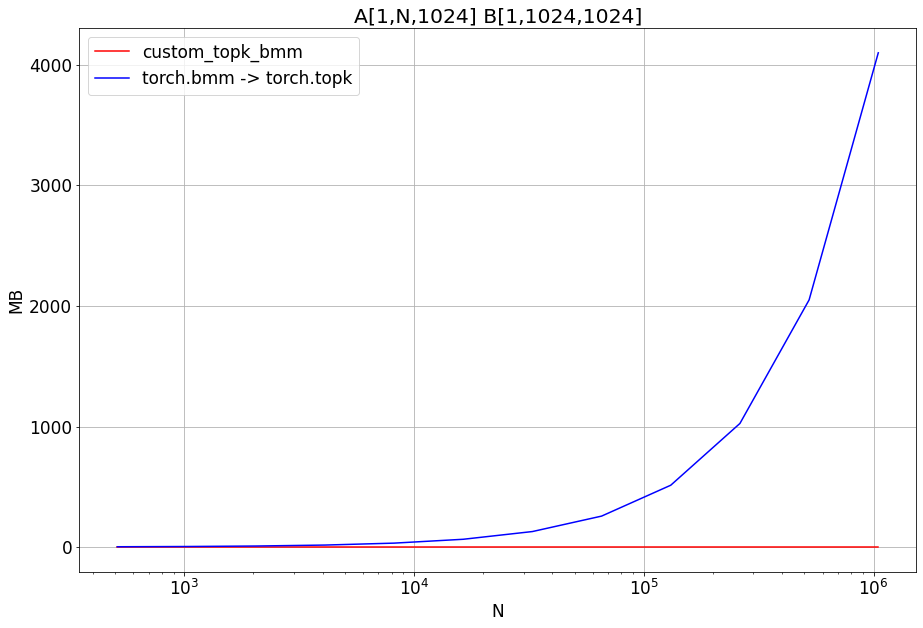

In [ ]:
#@title Grid test TopkBMM (Memory Footprint)
ls = [1]
ms = [256* 2**i for i in range(1, 13)]
ns = [1024]

ks = [1024]
mode="nn"

custom_res = dict()
cublass_res = dict()
for l in ls:
  for n in ns:
    for m in ms:
      for k in ks:     
        res = test_topk_bmm(
          l, m, n, k,
          mode=mode, n_iter=1, dim=1,
          n_candidates = 128,
        )
        cublass_res[m] = res[0] / 1024**2
        custom_res[m] = res[1] / 1024**2


plt.figure(figsize=(15, 10) )
plt.tight_layout()
plt.xlabel("N", fontsize=17)
plt.ylabel("MB", fontsize=17)
title = f"A[{l},N,{k}] B[{l},{k},{n}]"
plt.title(title)
plt.rcParams["font.size"] = "17"
plt.grid()
colors = ["red", "blue"]
labels = ["custom_topk_bmm", "torch.bmm -> torch.topk"]
for i, res in enumerate([custom_res, cublass_res]):
  res_x = list(res.keys())
  res_y = list(res.values())
  # plt.plot(
  # plt.loglog(
  plt.semilogx(
    res_x,
    res_y,
    color=colors[i],
    label=labels[i],
  )
  # plt.plot(res_x, res_y, colors[i])
plt.legend()
plt.savefig("imgs/topk_bmm_" + title + "_memory_semilogx")
plt.show()

In [ ]:
#@title Grid test TopkBMM (Runtime)
ls = [1]
ms = [256* 2**i for i in range(1, 13)]
ns = [1024]

ks = [1024]
mode="nn"

custom_res = dict()
cublass_res = dict()
for l in ls:
  for n in ns:
    for m in ms:
      for k in ks:     
        res = test_topk_bmm(
          l, m, n, k,
          mode=mode, n_iter=15, dim=1,
          n_candidates = 128,
        )
        cublass_res[m] = res[0]*1e3
        custom_res[m] = res[1]*1e3


plt.figure(figsize=(15, 10) )
plt.tight_layout()
plt.xlabel("N", fontsize=17)
plt.ylabel("milliseconds", fontsize=17)
title = f"A[{l},N,{k}] B[{l},{k},{n}]"
plt.title(title)
plt.rcParams["font.size"] = "17"
plt.grid()
colors = ["red", "blue"]
labels = ["custom_topk_bmm", "torch.bmm -> torch.topk"]
for i, res in enumerate([custom_res, cublass_res]):
  res_x = list(res.keys())
  res_y = list(res.values())
  # plt.plot(
  # plt.loglog(
  plt.semilogx(
    res_x,
    res_y,
    color=colors[i],
    label=labels[i],
  )
  # plt.plot(res_x, res_y, colors[i])
plt.legend()
plt.savefig("imgs/topk_bmm_" + title + "_semilogx")
plt.show()